<a href="https://colab.research.google.com/github/mayankbrn/9.12_Clustering_learners/blob/MA-Working/Clustering_learners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Learners

## EDA

In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Importing datset

In [345]:
!gdown 1LS3ATtyGh4_BNXTEkWwjcXZrvLRnppSs

Downloading...
From: https://drive.google.com/uc?id=1LS3ATtyGh4_BNXTEkWwjcXZrvLRnppSs
To: /content/12_scaler_clustering.csv
100% 24.7M/24.7M [00:00<00:00, 135MB/s]


In [346]:
df = pd.read_csv('/content/12_scaler_clustering.csv')
df.head()

,Unnamed: 0,company_hash,email_hash,orgyear,ctc,job_position,ctc_updated_year
0,0,atrgxnnt xzaxv,6de0a4417d18ab14334c3f43397fc13b30c35149d70c05...,2016.0,1100000,Other,2020.0
1,1,qtrxvzwt xzegwgbb rxbxnta,b0aaf1ac138b53cb6e039ba2c3d6604a250d02d5145c10...,2018.0,449999,FullStack Engineer,2019.0
2,2,ojzwnvwnxw vx,4860c670bcd48fb96c02a4b0ae3608ae6fdd98176112e9...,2015.0,2000000,Backend Engineer,2020.0
3,3,ngpgutaxv,effdede7a2e7c2af664c8a31d9346385016128d66bbc58...,2017.0,700000,Backend Engineer,2019.0
4,4,qxen sqghu,6ff54e709262f55cb999a1c1db8436cb2055d8f79ab520...,2017.0,1400000,FullStack Engineer,2019.0


### Basic checks

In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        205843 non-null  int64  
 1   company_hash      205799 non-null  object 
 2   email_hash        205843 non-null  object 
 3   orgyear           205757 non-null  float64
 4   ctc               205843 non-null  int64  
 5   job_position      153279 non-null  object 
 6   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(2), object(3)
memory usage: 11.0+ MB


In [348]:
df.describe() #numeric data

,Unnamed: 0,orgyear,ctc,ctc_updated_year
count,205843.000000,205757.000000,2.058430e+05,205843.000000
mean,103273.941786,2014.882750,2.271685e+06,2019.628231
std,59741.306484,63.571115,1.180091e+07,1.325104
min,0.000000,0.000000,2.000000e+00,2015.000000
25%,51518.500000,2013.000000,5.300000e+05,2019.000000
50%,103151.000000,2016.000000,9.500000e+05,2020.000000
75%,154992.500000,2018.000000,1.700000e+06,2021.000000
max,206922.000000,20165.000000,1.000150e+09,2021.000000


In [349]:
df.describe(include = ['object']) # Categorical data

,company_hash,email_hash,job_position
count,205799,205843,153279
unique,37299,153443,1016
top,nvnv wgzohrnvzwj otqcxwto,bbace3cc586400bbc65765bc6a16b77d8913836cfc98b7...,Backend Engineer
freq,8337,10,43554


In [350]:
df['job_position'].value_counts()

,count
job_position,
Backend Engineer,43554
FullStack Engineer,24717
Other,18071
Frontend Engineer,10417
Engineering Leadership,6870
...,...
PhD. Student,1
Front-End Developer,1
ayS,1


In [351]:
df['job_position'].value_counts()[50:60] #position 51st to 60th based on the frequency of the roles
# mid-ranked job positions based on the frequency of the roles

,count
job_position,
Technology Analyst,10
Senior Software Engineer (Backend),10
Software Engineer (Full stack),9
SDE-1,9
Senior Consultant,9
Senior Systems Engineer,8
SDE2,8
Senior Engineer,8
Software Engineer I,8


### Data Processing

#### Dropping the nonn-necessary columns

Let's remove the 'Unnamed: 0' and email hash column. since we have removed email hash later it will help us in clustering based on the company name

In [352]:
# Dropping the email hash and company hash columns
df.drop(['Unnamed: 0', 'email_hash'], axis = 1, inplace = True)

In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205843 entries, 0 to 205842
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   company_hash      205799 non-null  object 
 1   orgyear           205757 non-null  float64
 2   ctc               205843 non-null  int64  
 3   job_position      153279 non-null  object 
 4   ctc_updated_year  205843 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 7.9+ MB


#### Cleaning the job_position column


In [354]:
# Lets see how can we transform
import re #importing the regex library
mystring='\tAirtel\\\\&&**() X Labs'
re.sub('[^A-Za-z ]+', '', mystring)

'Airtel X Labs'

In [355]:
# Setting up the function to apply Regex on the stringsto remove the special characters
import re
def remove_special(string):
  new_string = re.sub('[^A-Za-z ]+', '', string)
  return new_string

In [356]:
# creating the function to clean a text columns
def clean_col(col):
  col = col.apply(lambda x : remove_special(str(x))) # remove any special char from the string
  col = col.apply(lambda x : x.lower()) # make the string lower char
  col = col.apply(lambda x : x.strip()) # remove any leading/lagging blank spaces
  return col

##### job_position_col

In [357]:
# Applying the function and assigning the clean data to the dataframe
df['job_position'] = clean_col(df['job_position'])
df['job_position'].head()

,job_position
0,other
1,fullstack engineer
2,backend engineer
3,backend engineer
4,fullstack engineer


In [358]:
df.shape

(205843, 5)

##### company_hash

In [359]:
df['company_hash'].value_counts().sort_index()

,count
company_hash,
0,2
0000,1
01 ojztqsj,2
05mz exzytvrny uqxcvnt rxbxnta,2
1,2
...,...
zyvzwt wgzohrnxzs tzsxzttqo,1
zz,2
zzb ztdnstz vacxogqj ucn rna,2


In [360]:
# lets apply the clean_col function on the company hash columns as well
df['company_hash'] = clean_col(df['company_hash'])
df['company_hash'].head()

,company_hash
0,atrgxnnt xzaxv
1,qtrxvzwt xzegwgbb rxbxnta
2,ojzwnvwnxw vx
3,ngpgutaxv
4,qxen sqghu


In [361]:
df['company_hash'].value_counts().sort_index()

,count
company_hash,
,89
a,1
a b onttr wgqu,1
a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx,1
a ntwy ogrhnxgzo ucn rna,2
...,...
zz,2
zz wgzztwn mya,1
zzb ztdnstz vacxogqj ucn rna,2


In [362]:
df.shape

(205843, 5)

#### Removing the duplicate rows

In [363]:
# lets drop the duplicate rows of colum
df.drop_duplicates(inplace = True)

In [364]:
df.shape

(188245, 5)

#### removing rows without the company hash and job position

In [365]:
df = df[ ~( (df['company_hash'] == '') | (df['job_position']== '') )]
df.shape

(188152, 5)

#### Null values in OrgYear

In [366]:
df['orgyear'].isna().sum() #total null values on org year

86

Lets impute the null values for org year using the meadian org year for that company

In [367]:
company_median_year = df.groupby(['company_hash'])['orgyear'].median()
company_median_year

,orgyear
company_hash,
a,2017.0
a b onttr wgqu,2019.0
a j uvnxr owyggr ge tzsxzttqxzs vwvatbj vbmx,2015.0
a ntwy ogrhnxgzo ucn rna,2013.0
a ntwyzgrgsxto,2015.0
...,...
zz,2011.0
zz wgzztwn mya,2009.0
zzb ztdnstz vacxogqj ucn rna,2017.0


Now we intend to replace the null value in the org year with the median values for that particular company_hash

In [368]:
# writing a function to impute the null value of org year
def orgyear_imputation(table_with_median_value, col_with_company_hash, col_with_null_values):
  if np.isnan(col_with_null_values):
    return table_with_median_value[col_with_company_hash]
  else:
    return col_with_null_values

In [369]:
#lets apply above function and save the new values in the dataframe
df['orgyear'] = df.apply(lambda x: orgyear_imputation(company_median_year, x['company_hash'], x['orgyear']), axis = 1)
df['orgyear'].isna().sum()

26

In [370]:
# since still there are 26 org year values, lets drop them
df = df[~ df['orgyear'].isnull()] #where the orgyear is not null
df.isna().sum()

,0
company_hash,0
orgyear,0
ctc,0
job_position,0
ctc_updated_year,0


So Now there are no null values in any columns

#### Outlier removal

<Axes: xlabel='orgyear'>

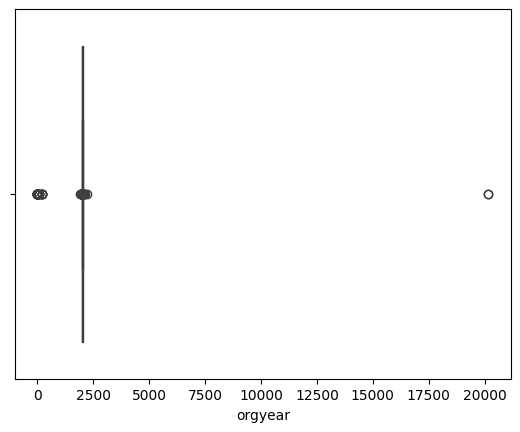

In [371]:
sns.boxplot(x = df['orgyear'])

In [372]:
# Removing the outliers from the orgyear column
q1 = df['orgyear'].quantile(0.25)
q3 = df['orgyear'].quantile(0.75)

iqr = q3 - q1 #Inter Quartile Range
# removing the outliers by filtering out the outliers (q1-1.5*iqr) and (q3+1.5*iqr)
df = df.loc[(df['orgyear'] >= (q1 - 1.5 * iqr)) & (df['orgyear'] <= (q3 + 1.5*iqr))]

<Axes: xlabel='orgyear'>

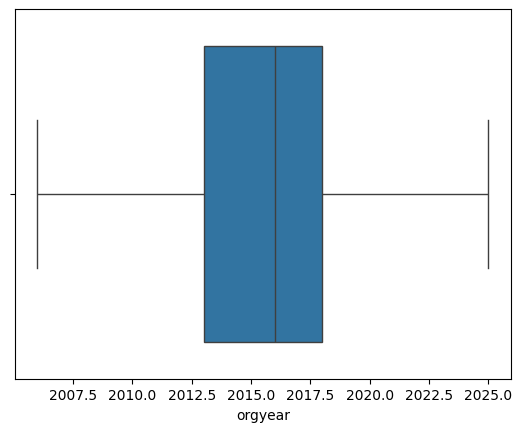

In [373]:
# Now lets try to create the box plot
sns.boxplot(x = df['orgyear'])

<Axes: xlabel='orgyear', ylabel='Count'>

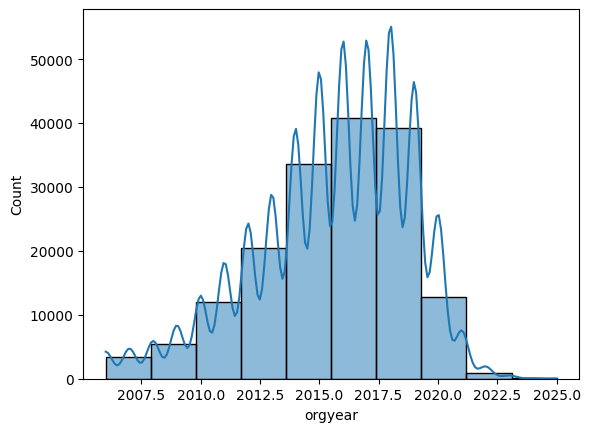

In [396]:
sns.histplot(x = df['orgyear'], bins = 10, kde = True)

<Axes: xlabel='ctc'>

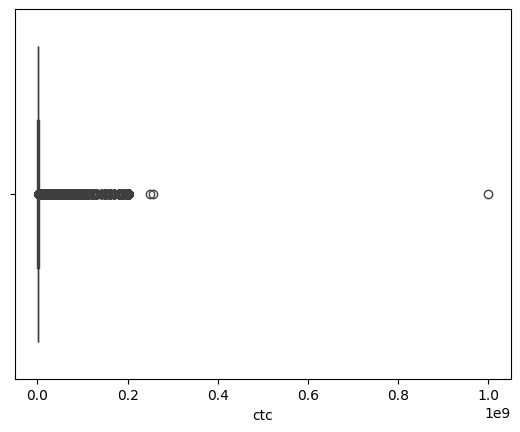

In [379]:
sns.boxplot(x = df['ctc'])

In [380]:
# Simialrly removing the outliers from the ctc column as well

# Removing the outliers from the orgyear column
q1_ctc = df['ctc'].quantile(0.25)
q3_ctc = df['ctc'].quantile(0.75)

iqr_ctc = q3_ctc - q1_ctc #Inter Quartile Range
# removing the outliers by filtering out the outliers (q1-1.5*iqr) and (q3+1.5*iqr)
df = df.loc[(df['ctc'] >= (q1_ctc - 1.5 * iqr_ctc)) & (df['ctc'] <= (q3_ctc + 1.5*iqr_ctc))]

<Axes: xlabel='ctc'>

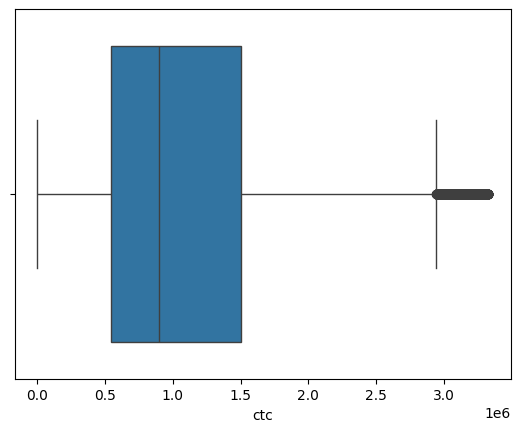

In [381]:
sns.boxplot(x = df['ctc'])

<Axes: xlabel='ctc', ylabel='Count'>

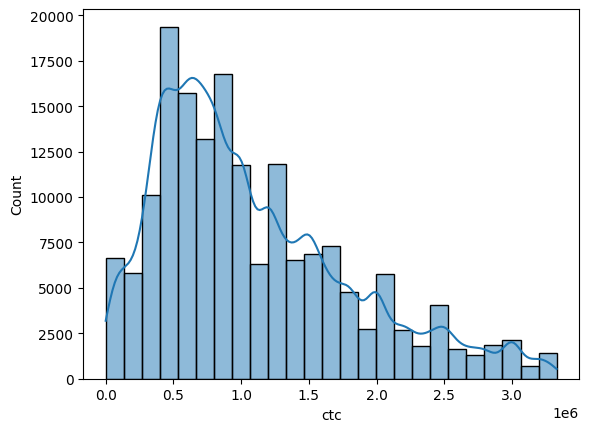

In [387]:
sns.histplot(df['ctc'], bins = 25, kde = True)

In [397]:
df.shape

(168986, 5)

In [400]:
df.drop_duplicates().shape

(168985, 5)

In [403]:
df['job_position'].sample(10)

,job_position
3873,backend engineer
80899,android engineer
93306,ios engineer
65692,nan
47247,backend engineer
160949,frontend engineer
133582,fullstack engineer
72926,devops engineer
28844,frontend engineer
14092,frontend engineer


There is actually 'nan' written as text in the job position column, lets replace them with the actual NaN

In [404]:
df['job_position'].replace('nan', np.nan, inplace=True)
df['job_position'].sample(10)

<ipython-input-404-0296cf221b64>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['job_position'].replace('nan', np.nan, inplace=True)


,job_position
130566,devops engineer
109569,NaN
59342,frontend engineer
87346,other
10641,backend engineer
26099,other
162345,NaN
195337,sdet
7586,other
41822,NaN
